In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from random import random
import json, os.path, pickle
import sys, time
from pathlib import Path
print(f"running python {sys.version}")

# condtional printing untility, only prints important messages
global verbosity
verbosity = 5
def pp(importance, message):
    if importance > 10-verbosity:
        print(message)



running python 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


Testing the learning curve mathematics based on three parameters.


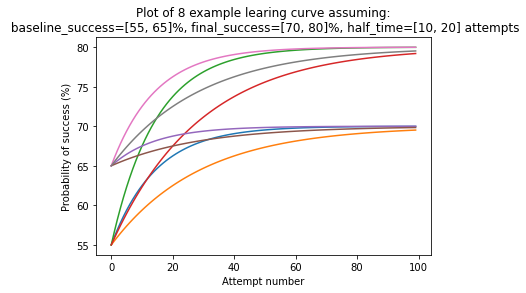

In [2]:
print("Testing the learning curve mathematics based on three parameters.")

def success_p(attempt, baseline_success, final_success, half_time):
    failure_risk = 0.5**(attempt/half_time) # in range 0 to 1
    return final_success - failure_risk *(final_success - baseline_success)

def plot_example_learning_curves():
    bs = [55, 65] # percent
    fs =[70,80] # percent
    ht = [10, 20]
    fig, ax = plt.subplots()
    for baseline_success in bs:
        for final_success in fs: # percent
            for half_time in ht: # cases
                x = np.array(range(0, 100))  
                y = success_p(attempt = x, baseline_success = baseline_success, final_success = final_success, half_time = half_time)
                plt.plot(x, y)  
    plt.title(f"Plot of {len(bs)*len(fs)*len(ht)} example learing curve assuming:\n baseline_success={bs}%, final_success={fs}%, half_time={ht} attempts")
    ax.set_ylabel('Probability of success (%)')
    ax.set_xlabel('Attempt number')
    plt.show()  

plot_example_learning_curves()

In [3]:
##
## Create a population of learning curves
## (as three seperate arrays of the defining parameters)
## 


"""
Make mock curves as defined by three lists of defining parameters:
* baseline success probablity (ie how well the student will do on first ever attempt)
* final sussess probability (ie how well this stuedent will eventually become)
* number of attempts to achieve half the improvement from baseline to final proficency
"""
def generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000):
    #baseline_success_p = 1/(1+np.random.exponential(odds_of_failure,n))
    # see https://towardsdatascience.com/beta-distribution-intuition-examples-and-derivation-cf00f4db57af
    baseline_success_p = np.random.beta(baseline_alpha, baseline_beta,n)
    failure_p = 1-baseline_success_p # baseline risk of failure 
    final_success_p = 1-(failure_p * (1-fall_in_failure_rate*np.random.random(n)))
    attempts_to_half_improvement = np.random.rayleigh(half_time_mean,n)
    return {"bsp": baseline_success_p, "fsp": final_success_p, "athi": attempts_to_half_improvement}

""" 
Describe a set of student curves, and optionally plot.
Return a dictionary of values.                      
"""
def describe_student_curves(sc, meta, chattiness=1):
    pp(chattiness, f"""      
    baseline_success_p = {sc['bsp'].mean():0.2f} (sd: {sc['bsp'].std():0.2f})
    final_success_p = {sc['fsp'].mean():0.2f} (sd: {sc['fsp'].std():0.2f})
    attempts_to_half_improvement = {sc['athi'].mean():0.2f} (sd: {sc['athi'].std():0.2f})
    """)    
    return {
      **meta,
      "baseline_success_p": sc['bsp'].mean(),
      "baseline_success_p_sd": sc['bsp'].std(),     
      "final_success_p": sc['fsp'].mean(), 
      "final_success_p_sd": sc['fsp'].std(),
      "attempts_to_half_improvement": sc['athi'].mean(),
      "attempts_to_half_improvement_sd": sc['athi'].std(),
      "key": f"{sc['bsp'].mean():0.2f}_{sc['bsp'].std():0.2f}_{sc['fsp'].mean():0.2f}_{sc['fsp'].std():0.2f}_{sc['athi'].mean():0.2f}_{sc['athi'].std():0.2f}"
        }

def plot_student_curve(sc):
    n = len(sc['bsp'])
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 2))
    count, bins, ignored = ax0.hist(sc['bsp'], bins=100, density=True, alpha=0.6, label="Baseline")
    count, bins, ignored = ax0.hist(sc['fsp'], bins=100, density=True, alpha=0.6, range=(0,1), label="Final")
    ax0.axis((0,1,0,n/200))
    ax0.set_title("Distribution of student's success probability")
    ax0.set_xlabel('Probability of success')
    ax0.legend()
    ax0.set(yticklabels=[]) 
    count, bins, ignored = ax1.hist(sc['athi'], bins=100, density=False)
    ax1.set_title("Distribution of student's attempts\nto make half ultimate improvement")
    ax1.set_xlabel('Attempt number')
    ax1.set(yticklabels=[]) 
    fig.tight_layout()
    plt.show()

""" 
Implement the student curve by calculating the probability of success at a given attempt. 
""" 
def student_p(student_id, attempt, sc):
    failure_risk = 0.5**(attempt/sc['athi'][student_id]) # in range 0 to 1
    return sc['fsp'][student_id] - failure_risk *(sc['fsp'][student_id] - sc['bsp'][student_id])
        
"""
create a 2d array of student success probabilities
"""
def student_attempt_success(sc, attempts=20):
    n = len(sc['bsp'])
    students = np.array(range(0, n))
    attempts = np.array(range(0, attempts))
    # make a matrix from the above two arrays
    return student_p(students[:,np.newaxis],attempts[np.newaxis,:],sc)    

def succeeded(p, success_relative_increase):
    random_roll = np.random.random(p.shape)
    modified_success = 1 - ((1-p)/(1+success_relative_increase))
    pp(7, f"P initial: {p.mean():0.3}  P after adjustment: {modified_success.mean():0.3}; dice: {random_roll.mean():0.3}")
    return random_roll < modified_success

def create_mock_students(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000, chattiness = 5):
    # baseline "beta" curve defining initial success rate
    sc = generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n)
    sac = student_attempt_success(sc, attempts=20)
    pp(chattiness, f"Generated attempt success curves for {n} students.")
    return sc, sac

loaded student_sets.pickle
'variable' (2000 students)


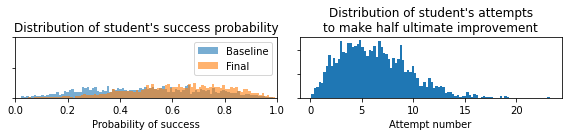

'uniform' (2000 students)


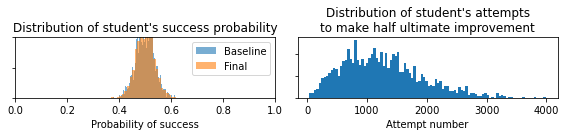

'initial' (2000 students)


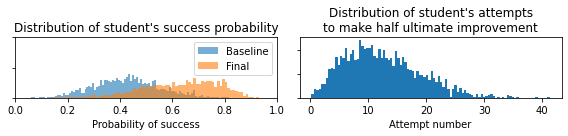

'second' (2000 students)


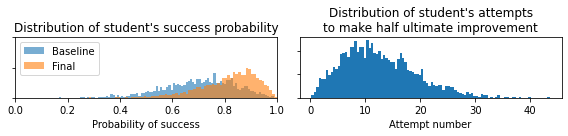

,baseline_alpha,baseline_beta,fall_in_failure_rate,half_time_mean,baseline_success_p,baseline_success_p_sd,final_success_p,final_success_p_sd,attempts_to_half_improvement,attempts_to_half_improvement_sd,key,sc,sac
variable,2,2,0.50,5,0.499557,0.221390,0.624239,0.183931,6.265773,3.319677,0.50_0.22_0.62_0.18_6.27_3.32,"{'bsp': [0.45914679633914146, 0.41697799738208...","[[0.45914679633914146, 0.48021341207637047, 0...."
uniform,100,100,0.00,1000,0.499784,0.035511,0.499784,0.035511,1255.292396,655.457881,0.50_0.04_0.50_0.04_1255.29_655.46,"{'bsp': [0.48490432507156345, 0.42329162479280...","[[0.48490432507156345, 0.48490432507156345, 0...."
initial,6,8,0.70,10,0.427198,0.126695,0.629988,0.142840,12.453025,6.512537,0.43_0.13_0.63_0.14_12.45_6.51,"{'bsp': [0.44079158643145894, 0.46385496642229...","[[0.44079158643145894, 0.4433837719001402, 0.4..."
second,7,3,0.75,10,0.702940,0.134076,0.815079,0.108070,12.583497,6.689264,0.70_0.13_0.82_0.11_12.58_6.69,"{'bsp': [0.7184879706390098, 0.620722833702979...","[[0.7184879706390098, 0.7258838691336087, 0.73..."


In [4]:
"""
Create and cache a set of student curves
"""
def make_student_sets(n=100, chattiness=1):
    metas = {
        "variable": {
            "baseline_alpha": 2,
            "baseline_beta": 2,
            "fall_in_failure_rate": 0.5, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 5, # how quickly to students learn?
        },
        "uniform": {
            "baseline_alpha": 100,
            "baseline_beta": 100,
            "fall_in_failure_rate": 0, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 1000, # how quickly to students learn?
        },
        "initial": {
            "baseline_alpha": 6,
            "baseline_beta": 8,
            "fall_in_failure_rate": .7, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 10, # how quickly to students learn?
        },
        "second": {
            "baseline_alpha": 7,
            "baseline_beta": 3,
            "fall_in_failure_rate": .75, # how much do they improve (or does their failure rate drop)
            "half_time_mean": 10, # how quickly to students learn?
        }
    }
    student_sets = {}
    for name, meta in metas.items():
        print(f"Making {name} {n}")
        sc, sac = create_mock_students(
            baseline_alpha = meta['baseline_alpha'], 
            baseline_beta = meta['baseline_beta'],
            fall_in_failure_rate = meta['fall_in_failure_rate'], # how much do they improve (or does their failure rate drop)
            half_time_mean = meta['half_time_mean'], # how quickly to students learn?
            chattiness=chattiness, n = n)   
        final_meta = describe_student_curves(sc, meta)
        student_sets[name] = {**final_meta, "sc":sc,"sac":sac}
    return student_sets


def load_student_sets(testing=True, student_sets_file_prefix=False, overwrite=False):
    if testing:
        student_sets = pd.DataFrame.from_dict(make_student_sets(chattiness = 10, n=2000), orient='index')
    else:
        pickle_file = f"{student_sets_file_prefix}.pickle"
        if os.path.isfile(pickle_file) and not overwrite:
            with open(pickle_file, 'rb') as f:
                student_sets = pickle.load(f)
            pp(8, f"loaded {pickle_file}")
        else:
            pp(8, "generating")
            student_sets = pd.DataFrame.from_dict(make_student_sets(n=2000), orient='index')
            with open(pickle_file, 'wb') as f:
                pickle.dump(student_sets, f)
            pp(8, f"saved {pickle_file}")
    return student_sets

def plot_student_curves(student_sets):
    for set_name, meta in student_sets.iterrows():
        print(f"'{set_name}' ({len(meta['sc']['bsp'])} students)")
        plot_student_curve(meta['sc'])

student_sets_file_prefix = 'student_sets'
student_sets = load_student_sets(student_sets_file_prefix=student_sets_file_prefix, testing=False)
plot_student_curves(student_sets)
student_sets

In [ ]:
def generate_trial_data(subject_n, attempt_n, trials, groups, sac):
    attempt_data = []
    participant_data = []
    trial_data = []
    totals = {}
    attempts_per_group = trials*subject_n*attempt_n
    print(f"{attempts_per_group} total attempts per group")
    for trial in range(trials):
        pp(7,f"=======\ntrial {trial}")
        for group, success_relative_increase in groups.items():
            pp(6, f"group: {group}")
            students = sac[np.random.choice(len(sac), subject_n, replace=True), :attempt_n]
            pp(5,students)
            result = succeeded(students,success_relative_increase)
            pp(6, f"result: {result}")
            pp(6, f"{group} success: {result.sum()}/{(result.size)} ({100*result.sum()/(result.size):3.1f}%)" )
            totals[group] = totals.get(group, 0) + result.sum()
            rec = {'trial': trial, 'group': group, "result": result.sum()}
            trial_data.append(rec)
            for p in range(subject_n):
                participant_results = result[p]
                rec["p"] = f"{group}{p}"
                prec = {**rec, "result": participant_results.sum()}
                pp(1,prec)
                participant_data.append(prec)
                for i in range(len(participant_results)):
                    irec = {**rec, "pint": p, "i": i, "result": 1 if participant_results[i] else 0}
                    pp(1,irec)
                    attempt_data.append(irec)

    pp(5, f"totals: {totals}")
    td = pd.DataFrame(trial_data)
    partd = pd.DataFrame(participant_data)
    ad = pd.DataFrame(attempt_data)
    return td, partd, ad, totals

In [ ]:
def trial_plots(td, partd, ad, box=False):
    if box:
        whisker = 5
        ax = sns.boxplot(x="group", y="result", data=td, whis=[whisker, 100-whisker])
        title_msg =  " (Whiskers at {whisker}% and {100-whisker}%)"
    else:
        title_msg =  ""
    #ax = sns.swarmplot(x="group", y="result", data=td)
    ax = sns.violinplot(x="group", y="result", data=td)
    ax.set_ylabel('Successes (count)')
    ax.set_xlabel('Group')
    plt.title(f"Successful attempts in each arm of {ad.trial.max()+1} trials of {int(len(partd)/len(td))} students, each having {int(len(ad)/len(partd))} attempts.{title_msg}")
    plt.show()
    pd.crosstab(ad.result, ad.i).plot(kind='bar')
    plt.title("Success per iteration")
    plt.show()
    ad.groupby(['group', 'i']).result.sum().plot(stacked=True,kind='bar')
    plt.title("Success per iteration")
    plt.show()
    
def test_trial_generation(sac, groups, subject_n = 5, attempt_n = 5, trials = 1000):
    global verbosity
    verbosity = 10 if trials < 3 else 6 if trials < 10 else 2  # range of 0-10
    print(f"verbosity: {verbosity}")
    print(f"{trials} trials sampling {subject_n} for each of {len(groups)} groups out of {sac.shape[0]} students, each having {attempt_n} attempts")
    td, partd, ad, totals = generate_trial_data(subject_n, attempt_n, trials, groups, sac)

    def sumarise_trial(totals, attempts_per_group):
        results_percents = {}
        for group, result in totals.items():
            print(group, result)
            results_percents[group] = 100*result/attempts_per_group
        print(results_percents)
    sumarise_trial(totals, attempts_per_group=subject_n*attempt_n*trials)

    return td, partd, ad

# groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "nodif": 0}
#td, partd, ad = test_trial_generation(sac, groups)

In [ ]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.formula.api import gee

"""
see: https://www.statsmodels.org/dev/_modules/statsmodels/genmod/cov_struct.html#CovStruct 
"""
def fit_models(ad, trials_to_test, tests):
    report_style = 'flat'
    outcomes = {}
    for trial in trials_to_test:
        if not trial % 100:
            print(">",end='')
        pp(5, f"#### trial: {trial} #####")
        itd = ad.query(f"trial == {trial}") # individual trial data
        c = itd[['group','result']].groupby("group").sum().reset_index().set_index("group")
        res = False # reset to prevent accidental carryover
        for model in tests:
            pp(5, f"#### {model}")
            if model == 'ols':
                res = ols('result ~ C(group)+i', data=itd).fit()
            elif model == 'geeB':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'geeBI':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'geeBIs': # drop the "i" variable (which tracks attempt number)
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            elif model == 'gee':
                fam = sm.families.Poisson()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            else:
                raise(f"bad model: {model}")
            pp(3, res.summary())
            p=res.pvalues[1]
            outcome = 'ns' if p > 0.05 else 'wrong' if c['result'][0] > c['result'][1] else 'sig' if p> 0.01 else 'vsig'
            pp(6, f"******************p = {p:0.6f} -{outcome}")
            if report_style == 'flat':
                key = f"{model}{outcome}"
                if outcomes.get(key, -1) == -1:
                    outcomes.update({f"{model}wrong":0,f"{model}ns":0,f"{model}sig":0,f"{model}vsig":0,f"{model}p":0})
                outcomes[key] += 1
                outcomes[f"{model}p"] += p

            else:
                outcomes[model] = outcomes.get(model,{'wrong':0,'ns':0,'sig':0,'vsig':0})
                outcomes[model][outcome] = 1 + outcomes[model].get(outcome, 0)

    return(outcomes)


In [ ]:
def read_trials(trial_cache_dir):
    pp(10, f'reading {trial_cache_dir}')
    ad = pd.read_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd = pd.read_csv(f"{trial_cache_dir}/partd.csv")
    td = pd.read_csv(f"{trial_cache_dir}/td.csv")
    return td, partd, ad
    pp(10, 'done')

def write_trials(td, partd, ad, trial_cache_dir, overwrite=False):
    Path(trial_cache_dir).mkdir(parents=True, exist_ok=not overwrite)
    pp(10, f'writing {trial_cache_dir}')
    ad.to_csv(f"{trial_cache_dir}/ad.csv.gzip", compression='gzip')
    partd.to_csv(f"{trial_cache_dir}/partd.csv")
    td.to_csv(f"{trial_cache_dir}/td.csv")
    pp(10, 'done')

def get_trials(student_sets, trialn = 100, subject_n = 200, attempt_n = 20):
    trials = {}
    for student_set_name, student_meta in student_sets.iterrows():
        print(f"'{student_set_name}' ({len(student_meta['sc']['bsp'])} students)")
        trial_cache_dir = f"trial_cache/{student_set_name}_{trialn}_{subject_n}_{attempt_n}"
        if os.path.isdir(trial_cache_dir):
            td, partd, ad = read_trials(trial_cache_dir)
        else:
            print(f"generating fresh trial data")
            print(f"using '{student_set_name}' ({len(student_meta['sc']['bsp'])} students)")
            groups = {"control": 0, "interventionA":0.1, "interventionB":0.2,
                      "interventionBa":0.4, "interventionBb":0.5,
                      "interventionC":0.6, "interventionD": 0.8, "nodif": 0}
            td, partd, ad = test_trial_generation(student_meta['sac'], groups, subject_n = subject_n, attempt_n = attempt_n, trials = trialn)
            write_trials(td, partd, ad, trial_cache_dir, overwrite=False)
        trials[student_set_name] = {"td":td,"partd":partd,"ad":ad}
    return trials

## add some more arms to the trials and save in new directory
"""
if addintervention:
    new_trial_cache_dir = f"{trial_cache_dir}e"
    groups = {"interventionBa":0.4, "interventionBb":0.5}
    pop_type = 'tight'
"""                 
def extend_trial(td, partd, ad, groups, new_trial_cache_dir, subject_n = 200, attempt_n = 20):
    print("generating extra trial data")
    trial_cache_dir = f"trial_cache_{pop_type}{trialn}"
    tde, partde, ade = test_trial_generation(sac, groups, subject_n = subject_n, attempt_n = attempt_n, trials = trialn)
    td = td.append(tde)
    ad = ad.append(ade)
    partd = partd.append(partd)
    write_trials(td, partd, ad, new_trial_cache_dir)


#trials = get_trials(student_sets, trialn = 10, subject_n = 10, attempt_n = 5)     
trials = get_trials(student_sets, trialn = 100, subject_n = 400, attempt_n = 20)     

In [ ]:
print("Summary of trials done on different student populations")
for student_set, trial in trials.items():
    ad = trial['ad']
    group_totals = ad[['group','result']].groupby('group').agg(['mean', 'sum', 'count'])
    print(student_set)
    display(group_totals)
    trial_plots(trial['td'], trial['partd'], trial['ad'])

In [ ]:
def run_sym(student_set, attempt_data, pairs, tests, trials_to_test, spg, aps,
    run_key="A",cache_path="cache/"):
    print('.', end='')
    global verbosity
    verbosity = 6 if trials_to_test < 5 else 4
    sym_results = []
    for comparision, pair in pairs.items():
        for students_per_group in spg: #[5, 10]:
            for attempts_per_student in aps: #[5,10]:
                # attempt to read from a cache file
                key = f"{run_key}.{trials_to_test}{comparision}.{students_per_group}.{attempts_per_student}"
                file = f"{cache_path}/{student_set}/{key}.json"
                if os.path.isfile(file):
                    with open(file) as f:
                        rec = json.load(f)
                    pp(8, f"loaded {file}")
                else:
                    query = f"group == {pair} and pint < {students_per_group} and i < {attempts_per_student}"
                    trial_data = attempt_data.query(query)
                    pp(10, f"`{query}` ({len(trial_data)} total attempts)")
                    run_results = fit_models(ad=trial_data, trials_to_test=range(trials_to_test), tests=tests)
                    pp(10, f"run_results: {run_results}")
                    rec = {"student_set": student_set,
                         "comparision":comparision, 
                         "students_per_group": students_per_group, 
                         "attempts_per_student": attempts_per_student,
                         "groupA": pair[0], "groupB": pair[1], 
                         "total_attempts": len(trial_data),
                         "trials": trials_to_test,
                         **run_results,
                         'query': query, 'time':time.time()*1000,
                         'key': key}
                    Path(os.path.dirname(file)).mkdir(parents=True, exist_ok=True) # make the cache dir
                    with open(file, 'w') as f:
                        pp(8, f"saving {file}")
                        json.dump(rec, f)
                sym_results.append(rec)
    return pd.DataFrame(sym_results)

In [ ]:
def run_test(testing = True, phase=0):
    pairs = {'none': ['control','nodif'],
                 'vsmall': ['control','interventionA'],
                 'small': ['control','interventionB'],
                 'mod': ['control','interventionBa'],
                 'mod1': ['control','interventionBb'],
                 'big': ['control', 'interventionC'],
                 'huge': ['control', 'interventionD'],
                 'upper': [ 'interventionC', 'interventionD']
                }
    if testing:
        students_per_group = [5]
        attempts_per_student = [5]
        trials_to_test = 3
        cache = "cache_test/"
    else:
        students_per_group = [30] if phase == 0 else [30, 75, 100] if phase == 1 else [20, 30, 50, 75, 100, 200, 400]
        attempts_per_student = [10] if phase < 2 else [10,20]
        trials_to_test = trials['uniform']['ad'].trial.max()+1
        cache="cache2/"

    print(f"testing {trials_to_test} trials")
    syms = [] # temporyary value replaced with a dataframe
    for student_set, trial in trials.items():
        ad = trial['ad']
        sym = run_sym(
            student_set = student_set,
            attempt_data = ad,
            pairs = pairs,
            run_key="d", tests = ['geeBIs'],
            trials_to_test = trials_to_test,
            spg = students_per_group,
            aps = attempts_per_student,
            #run_key="c",   tests = ['geeB','geeBI','geeBIs']
            cache_path=cache)
        # accumulate all the results into a single df
        syms = syms.append(sym) if len(syms) else sym
    return syms

In [ ]:
testing = False
#test3 = run_test(testing=testing)
#test4 = run_test(testing=False)
for phase in range(3):
    print(f"phase {phase}+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    test3 = run_test(testing=testing, phase=phase)
    test3.to_csv(f'test10a.{phase}.csv')
   

In [ ]:
def explain_pairs(pairs, trials):
    x = []
    for student_set, trial in trials.items():  
        d = trial['ad'][['group','result']].groupby('group').agg(['mean', 'sum', 'count'])
        for name, pair in pairs.items():
            m = [d.loc[pair[g]].result["mean"].real * 100 for g in range(2)]
            x1 = {"student_set": student_set, "pair": name, "ga": pair[0], "gb": pair[1], "a": m[0], "b": m[1], "dif": m[1] - m[0]}
            x.append(x1)
    return pd.DataFrame(x)
        

pairs = {'none': ['control','nodif'],
                 'vsmall': ['control','interventionA'],
                 'small': ['control','interventionB'],
                 'mod': ['control','interventionBa'],
                 'mod1': ['control','interventionBb'],         
                 'big': ['control', 'interventionC'],
                 'huge': ['control', 'interventionD'],
                 'upper': [ 'interventionC', 'interventionD']
                 }
explain_pairs(pairs, trials).to_csv("downstairs_pairs.csv")